In [1]:
# Loop through images in a folder
import os

# Replace with your main folder path
main_folder = './EDA_Analysis'

# List to store image file paths
tiff_files = []

# Walk through all directories and subdirectories
for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.lower().endswith(('.tif', '.tiff')):
            tiff_files.append(os.path.join(root, file))

print(f"Found {len(tiff_files)} TIFF images.")

# DISPLAY FILE NAMES
#for r in range (len(tiff_files)):
for r in range (5):
    print (tiff_files[r])

Found 20 TIFF images.
./EDA_Analysis/R1_28Aug23/R1_28Aug23_index_ndvi.tif
./EDA_Analysis/R1_28Aug23/R1_28Aug23_index_gndvi.tif
./EDA_Analysis/R1_28Aug23/R1_28Aug23_index_lai.tif
./EDA_Analysis/R1_28Aug23/R1_28Aug23_index_norm2.tif
./EDA_Analysis/R1_28Aug23/R1_28Aug23_index_ndre.tif


In [2]:
# Get the format |Region|Date|Indices|
for r in range (5):
    # file path
    file_path = tiff_files[r]
    # Get the filename without path
    filename = os.path.basename(file_path)
    
    # Remove extension
    name = os.path.splitext(filename)[0]
    
    # Split by underscores
    parts = name.split('_')
    
    # Extract components
    region = parts[0].lower()      # 'r1'
    date = parts[1]                # '7Sept23'
    index = '_'.join(parts[2:])    # 'index_norm2'


In [3]:
# Create an ordered dictionary and create Statistical variables (mean, median, mode, std_dev, var) in dictionary
import os
from collections import OrderedDict

# Main dictionary to hold metadata + empty stats section
Region = OrderedDict()

for r in range (len(tiff_files)):
   # file path
    file_path = tiff_files[r]
    # Get the filename without path
    filename = os.path.basename(file_path)
    
    # Remove extension
    name = os.path.splitext(filename)[0]
    
    # Split by underscores
    parts = name.split('_')
    #print (name)
    # Extract components
    region = parts[0].lower()      # 'r1'
    date = parts[1]                # '7Sept23'
    index = '_'.join(parts[2:])    # 'index_norm2'
    index = index.split('_')[1]
    
    #print (region, date, index)   
    Region[name] = OrderedDict([('region', region),
    ('date', date),
    ('index', index),
    ('mean', None),
    ('median', None),
    ('mode', None),
    ('std_dev', None),
    ('variance', None),
    ('pixel_values', [])])

#print (Region)

In [4]:
# plot histogram function
import rasterio
import numpy as np
from rasterio.windows import from_bounds
from scipy import stats  # Only needed for mode
import matplotlib.pyplot as plt

def statistical_measure (dict, sub_key_val, sub_value_val):
    hist_keys = []
    for key, value in dict.items():
        #print(f"File: {key}")
        for sub_key, sub_value in value.items():
            if sub_key == sub_key_val and sub_value == sub_value_val:
                for r in range (len(tiff_files)):    
                    if key in tiff_files[r]:
                        #print (tiff_files[r])
                        image_path = tiff_files[r]
                        with rasterio.open(image_path) as src:
                            # Extract image bounds and transform
                            bounds = src.bounds
                            transform = src.transform
                            nodata = src.nodata
                        
                            # Get window from bounding box
                            window = from_bounds(bounds.left, bounds.bottom, bounds.right, bounds.top, transform=transform)
                        
                            # Read the indice_values values in the bounding box
                            indice_values = src.read(1, window=window)
                        
                            # Mask nodata values
                            if nodata is not None:
                                indice_values = np.ma.masked_equal(indice_values, nodata)
                        # Flatten the array for stats
                        pixel_values = indice_values.compressed()     
                        Region[key]['pixel_values'] = pixel_values
                        Region[key]['mean'] = np.mean(pixel_values)
                        Region[key]['median'] = np.median(pixel_values)
                        Region[key]['mode'] = stats.mode(pixel_values, keepdims=True).mode[0]
                        Region[key]['std_dev'] = np.std(pixel_values)
                        Region[key]['variance'] = np.var(pixel_values)
                        hist_keys.append(key)
    return hist_keys

In [5]:
# Get pixel values of indices and plot histograms (NDVI) w.r.t indices
histogram_keys_ndvi = statistical_measure(Region, 'index', 'ndvi')
histogram_keys_gndvi = statistical_measure(Region, 'index', 'gndvi')
histogram_keys_lai = statistical_measure(Region, 'index', 'lai')
histogram_keys_norm2 = statistical_measure(Region, 'index', 'norm2')
histogram_keys_ndre = statistical_measure(Region, 'index', 'ndre')
#for key, value in Region.items():
#   print (key, value)

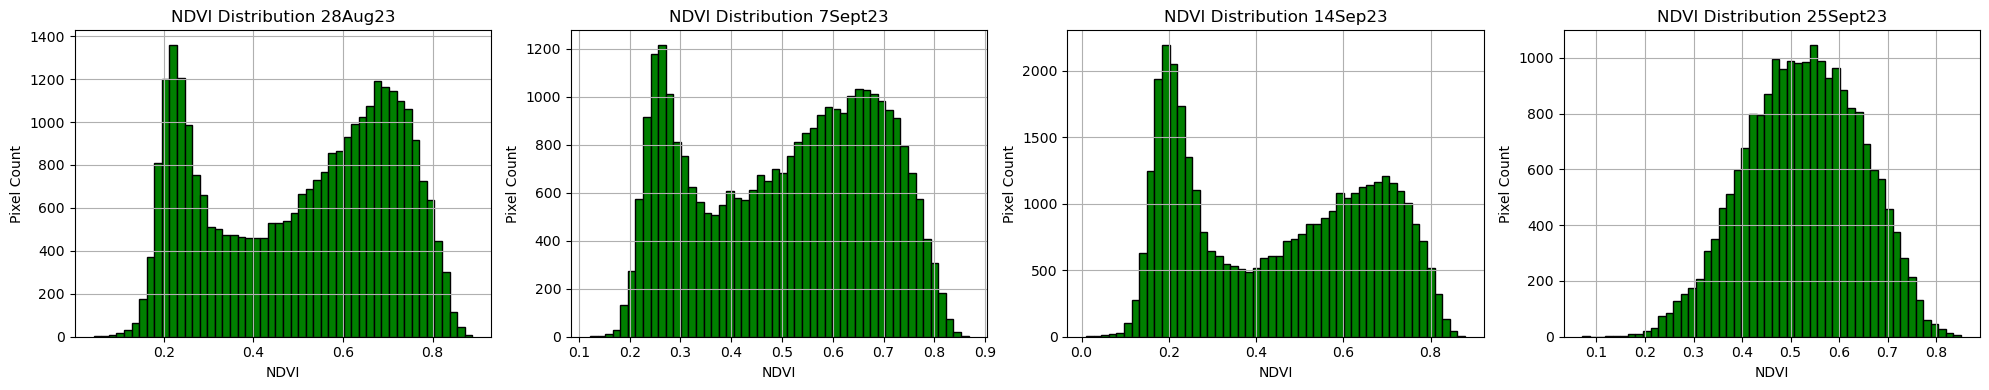

In [6]:
# Example: NDVI pixel values for 4 images
ax_len = len(histogram_keys_ndvi)
fig, axes = plt.subplots(1, ax_len, figsize=(20, 4))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    #print (histogram_keys_ndvi[i])
    #print (Region[histogram_keys_ndvi[i]]['date'])
    ax.hist(Region[histogram_keys_ndvi[i]]['pixel_values'], bins=50, color='green', edgecolor='black')
    ax.set_title(f"NDVI Distribution {Region[histogram_keys_ndvi[i]]['date']}")
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Pixel Count")
    ax.grid(True)

plt.tight_layout()
plt.show()

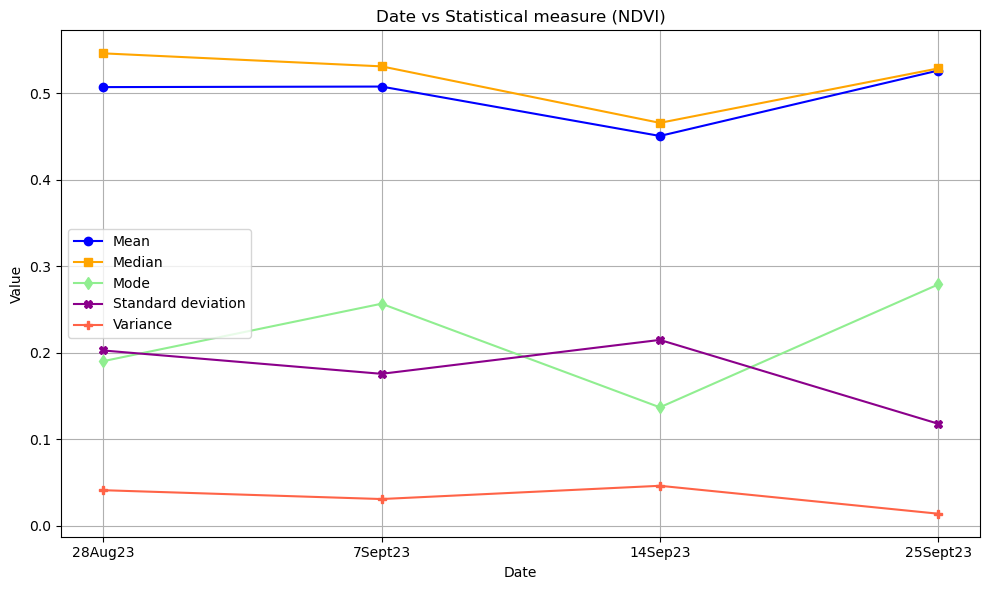

In [7]:
# Plot Statistical measure vs date (NDVI)
dates = []
means = []
medians = []
modes = []
std_devs = []
variances = []

for r in range(len(histogram_keys_ndvi)):
    dates.append(Region[histogram_keys_ndvi[r]]['date'])
    means.append(Region[histogram_keys_ndvi[r]]['mean'])
    medians.append(Region[histogram_keys_ndvi[r]]['median'])
    modes.append(Region[histogram_keys_ndvi[r]]['mode'])
    std_devs.append(Region[histogram_keys_ndvi[r]]['std_dev'])
    variances.append(Region[histogram_keys_ndvi[r]]['variance'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, means, marker='o', label='Mean', color='blue')
plt.plot(dates, medians, marker='s', label='Median', color='orange')
plt.plot(dates, modes, marker='d', label='Mode', color='lightgreen')
plt.plot(dates, std_devs, marker='X', label='Standard deviation', color='darkmagenta')
plt.plot(dates, variances, marker='P', label='Variance', color='tomato')
plt.title("Date vs Statistical measure (NDVI)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

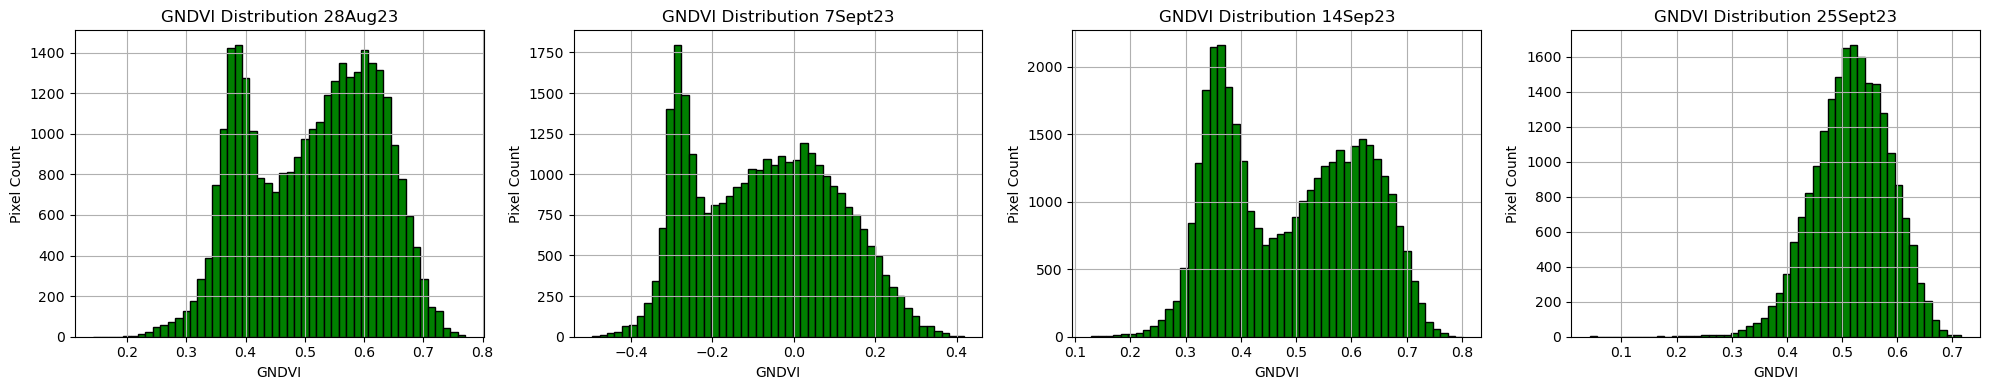

In [8]:
# Get pixel values of indices and plot histograms (GNDVI) w.r.t indices
ax_len = len(histogram_keys_gndvi)
fig, axes = plt.subplots(1, ax_len, figsize=(20, 4))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    #print (histogram_keys_ndvi[i])
    #print (Region[histogram_keys_ndvi[i]]['date'])
    ax.hist(Region[histogram_keys_gndvi[i]]['pixel_values'], bins=50, color='green', edgecolor='black')
    ax.set_title(f"GNDVI Distribution {Region[histogram_keys_gndvi[i]]['date']}")
    ax.set_xlabel("GNDVI")
    ax.set_ylabel("Pixel Count")
    ax.grid(True)

plt.tight_layout()
plt.show()

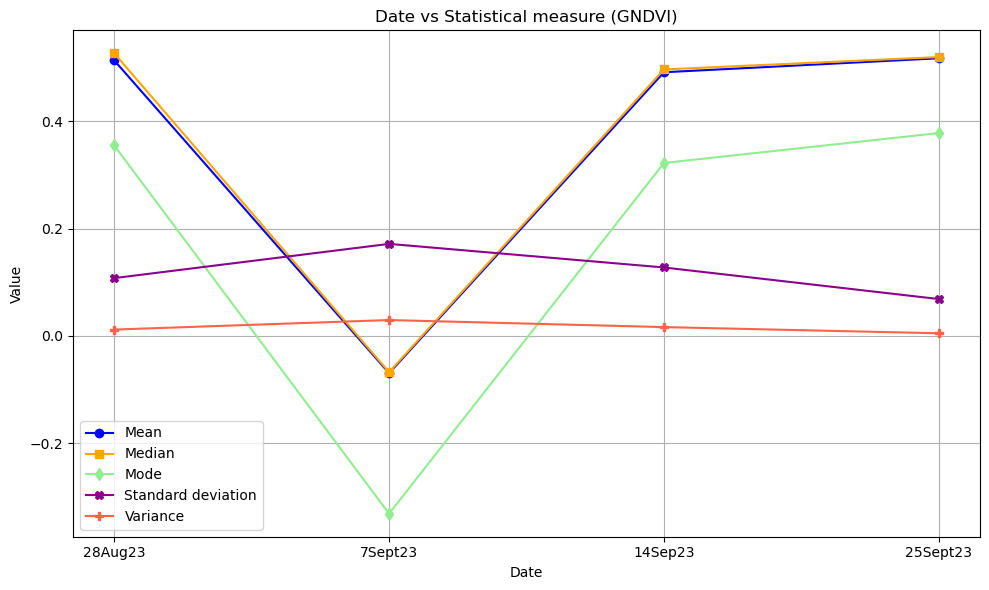

In [9]:
# Plot Statistical measure vs date (GNDVI)
dates = []
means = []
medians = []
modes = []
std_devs = []
variances = []

for r in range(len(histogram_keys_gndvi)):
    dates.append(Region[histogram_keys_gndvi[r]]['date'])
    means.append(Region[histogram_keys_gndvi[r]]['mean'])
    medians.append(Region[histogram_keys_gndvi[r]]['median'])
    modes.append(Region[histogram_keys_gndvi[r]]['mode'])
    std_devs.append(Region[histogram_keys_gndvi[r]]['std_dev'])
    variances.append(Region[histogram_keys_gndvi[r]]['variance'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, means, marker='o', label='Mean', color='blue')
plt.plot(dates, medians, marker='s', label='Median', color='orange')
plt.plot(dates, modes, marker='d', label='Mode', color='lightgreen')
plt.plot(dates, std_devs, marker='X', label='Standard deviation', color='darkmagenta')
plt.plot(dates, variances, marker='P', label='Variance', color='tomato')
plt.title("Date vs Statistical measure (GNDVI)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

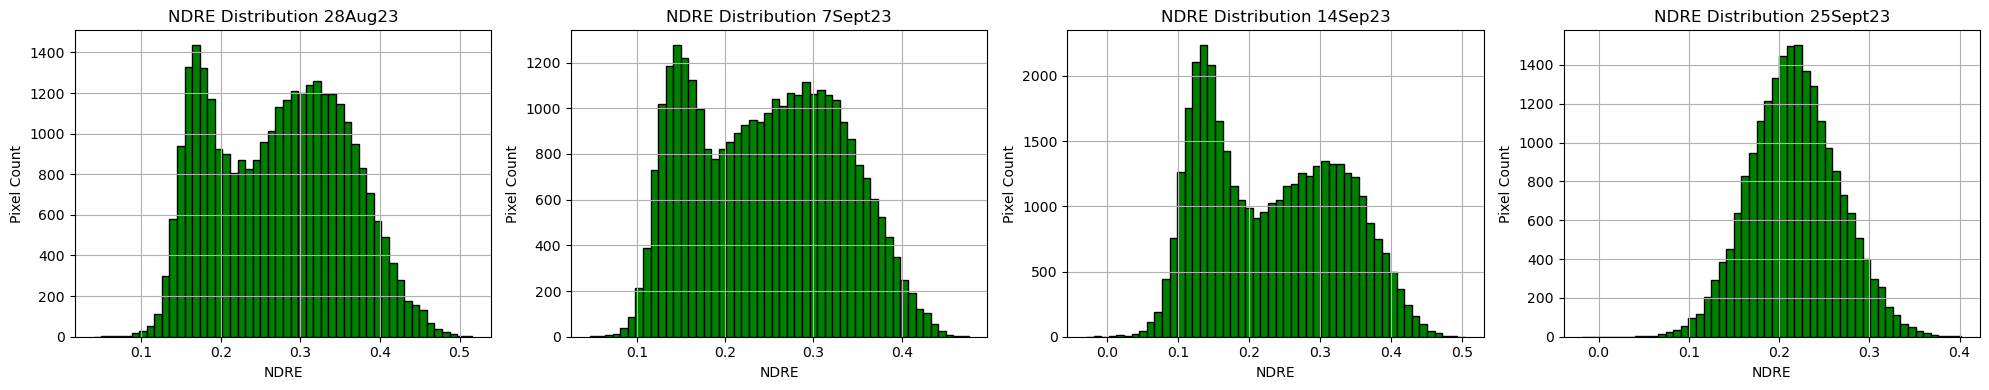

In [10]:
# Get pixel values of indices and plot histograms (NDRE) w.r.t indices
ax_len = len(histogram_keys_ndre)
fig, axes = plt.subplots(1, ax_len, figsize=(20, 4))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    ax.hist(Region[histogram_keys_ndre[i]]['pixel_values'], bins=50, color='green', edgecolor='black')
    ax.set_title(f"NDRE Distribution {Region[histogram_keys_ndre[i]]['date']}")
    ax.set_xlabel("NDRE")
    ax.set_ylabel("Pixel Count")
    ax.grid(True)

plt.tight_layout()
plt.show()

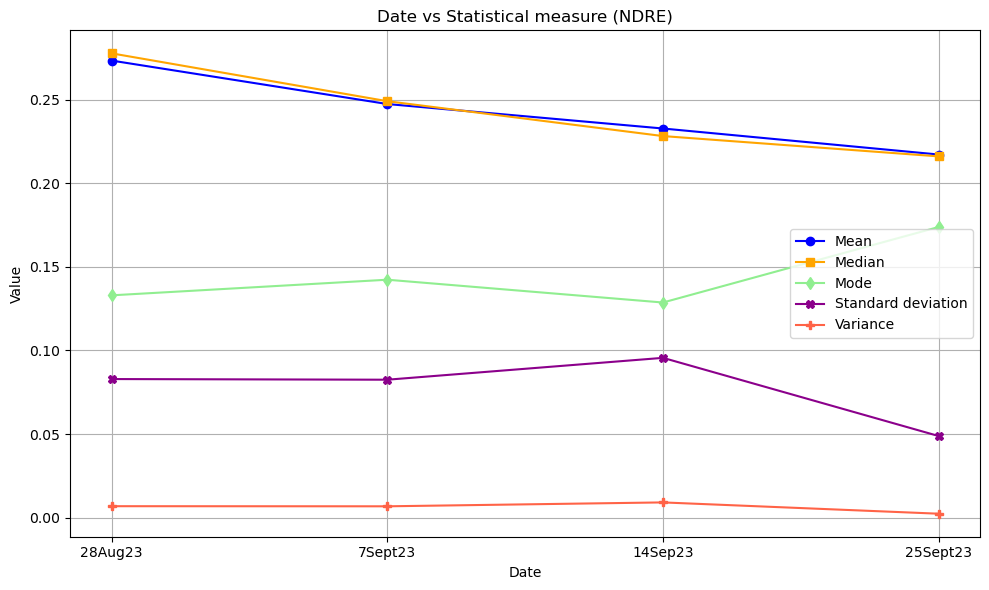

In [11]:
# Plot Statistical measure vs date (NDRE)
dates = []
means = []
medians = []
modes = []
std_devs = []
variances = []

for r in range(len(histogram_keys_ndre)):
    dates.append(Region[histogram_keys_ndre[r]]['date'])
    means.append(Region[histogram_keys_ndre[r]]['mean'])
    medians.append(Region[histogram_keys_ndre[r]]['median'])
    modes.append(Region[histogram_keys_ndre[r]]['mode'])
    std_devs.append(Region[histogram_keys_ndre[r]]['std_dev'])
    variances.append(Region[histogram_keys_ndre[r]]['variance'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, means, marker='o', label='Mean', color='blue')
plt.plot(dates, medians, marker='s', label='Median', color='orange')
plt.plot(dates, modes, marker='d', label='Mode', color='lightgreen')
plt.plot(dates, std_devs, marker='X', label='Standard deviation', color='darkmagenta')
plt.plot(dates, variances, marker='P', label='Variance', color='tomato')
plt.title("Date vs Statistical measure (NDRE)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

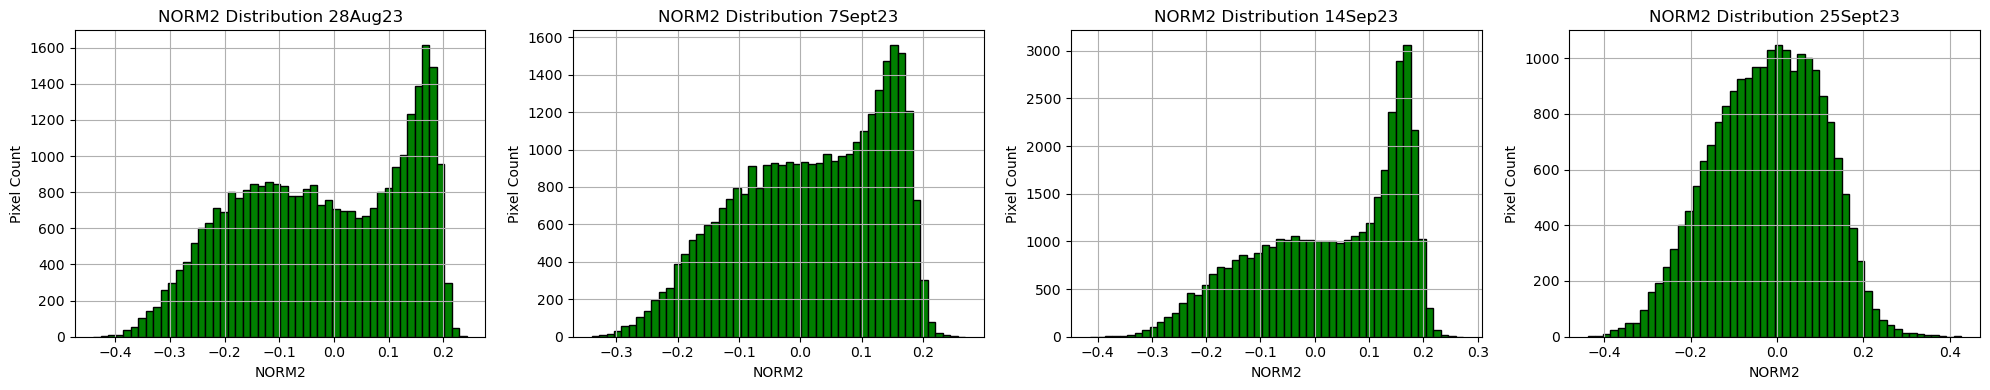

In [12]:
# Get pixel values of indices and plot histograms (NORM2) w.r.t indices
ax_len = len(histogram_keys_norm2)
fig, axes = plt.subplots(1, ax_len, figsize=(20, 4))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    ax.hist(Region[histogram_keys_norm2[i]]['pixel_values'], bins=50, color='green', edgecolor='black')
    ax.set_title(f"NORM2 Distribution {Region[histogram_keys_norm2[i]]['date']}")
    ax.set_xlabel("NORM2")
    ax.set_ylabel("Pixel Count")
    ax.grid(True)

plt.tight_layout()
plt.show()

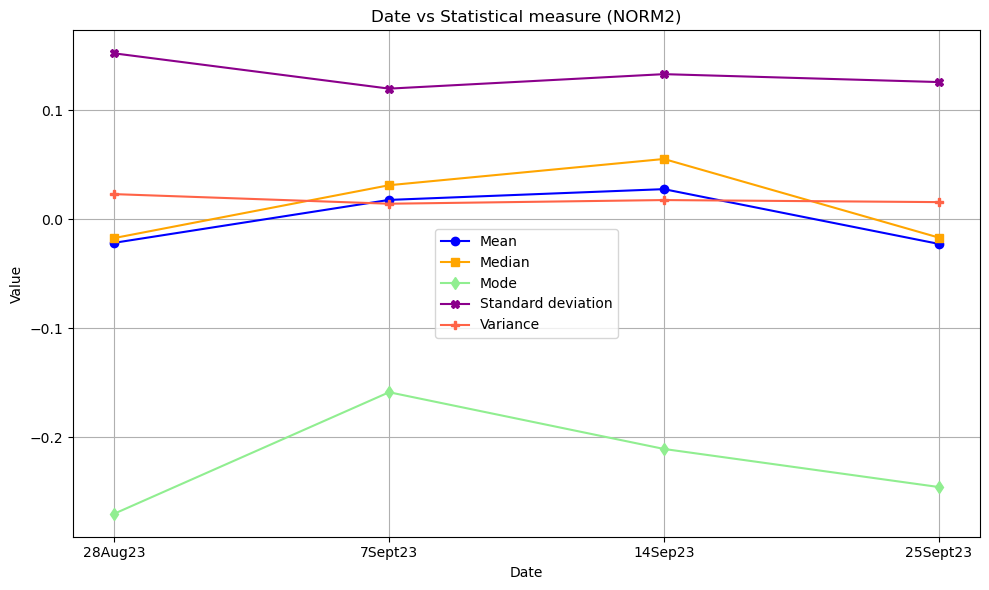

In [13]:
# Plot Statistical measure vs date (NORM2)
dates = []
means = []
medians = []
modes = []
std_devs = []
variances = []

for r in range(len(histogram_keys_norm2)):
    dates.append(Region[histogram_keys_norm2[r]]['date'])
    means.append(Region[histogram_keys_norm2[r]]['mean'])
    medians.append(Region[histogram_keys_norm2[r]]['median'])
    modes.append(Region[histogram_keys_norm2[r]]['mode'])
    std_devs.append(Region[histogram_keys_norm2[r]]['std_dev'])
    variances.append(Region[histogram_keys_norm2[r]]['variance'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, means, marker='o', label='Mean', color='blue')
plt.plot(dates, medians, marker='s', label='Median', color='orange')
plt.plot(dates, modes, marker='d', label='Mode', color='lightgreen')
plt.plot(dates, std_devs, marker='X', label='Standard deviation', color='darkmagenta')
plt.plot(dates, variances, marker='P', label='Variance', color='tomato')
plt.title("Date vs Statistical measure (NORM2)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

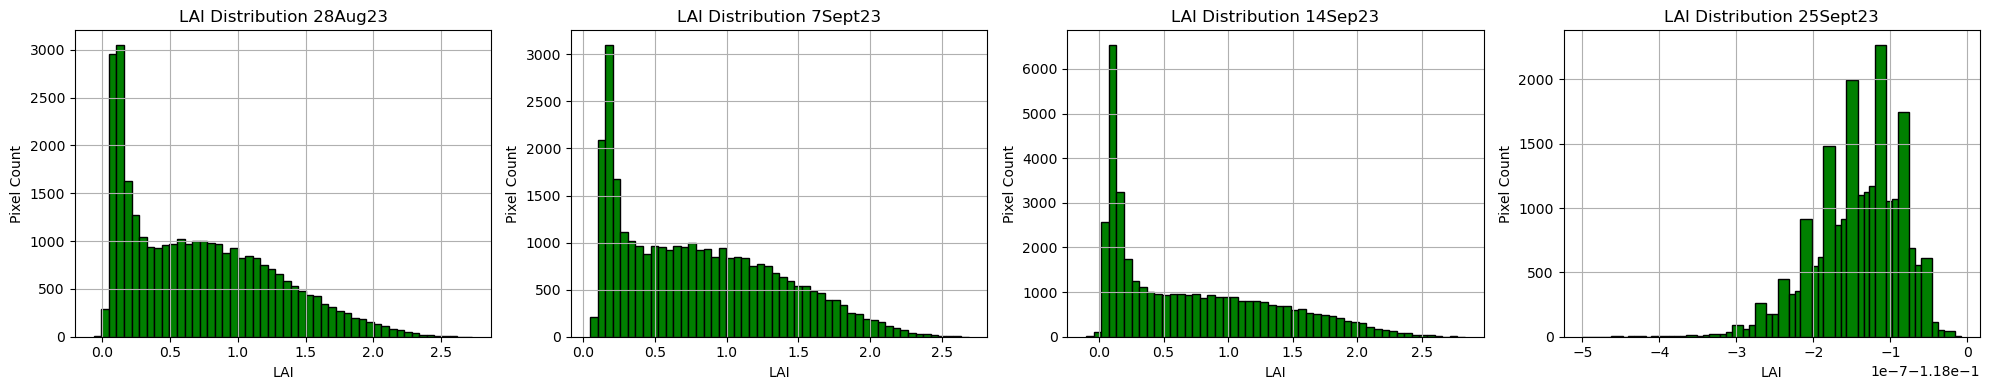

In [14]:
# Get pixel values of indices and plot histograms (LAI) w.r.t indices
ax_len = len(histogram_keys_lai)
fig, axes = plt.subplots(1, ax_len, figsize=(20, 4))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    ax.hist(Region[histogram_keys_lai[i]]['pixel_values'], bins=50, color='green', edgecolor='black')
    ax.set_title(f"LAI Distribution {Region[histogram_keys_lai[i]]['date']}")
    ax.set_xlabel("LAI")
    ax.set_ylabel("Pixel Count")
    ax.grid(True)

plt.tight_layout()
plt.show()

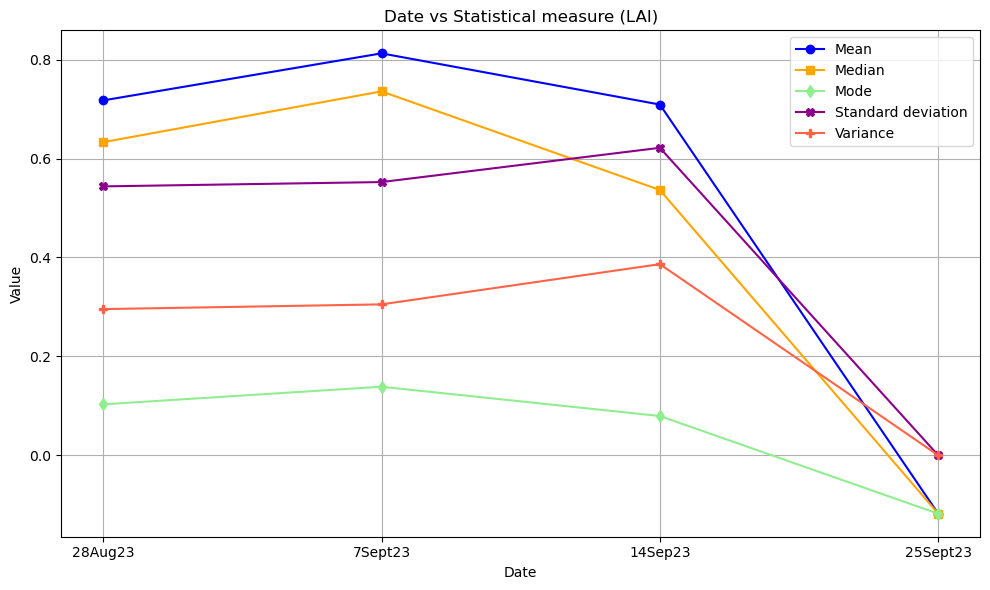

In [15]:
# Plot Statistical measure vs date (LAI)
dates = []
means = []
medians = []
modes = []
std_devs = []
variances = []

for r in range(len(histogram_keys_lai)):
    dates.append(Region[histogram_keys_lai[r]]['date'])
    means.append(Region[histogram_keys_lai[r]]['mean'])
    medians.append(Region[histogram_keys_lai[r]]['median'])
    modes.append(Region[histogram_keys_lai[r]]['mode'])
    std_devs.append(Region[histogram_keys_lai[r]]['std_dev'])
    variances.append(Region[histogram_keys_lai[r]]['variance'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, means, marker='o', label='Mean', color='blue')
plt.plot(dates, medians, marker='s', label='Median', color='orange')
plt.plot(dates, modes, marker='d', label='Mode', color='lightgreen')
plt.plot(dates, std_devs, marker='X', label='Standard deviation', color='darkmagenta')
plt.plot(dates, variances, marker='P', label='Variance', color='tomato')
plt.title("Date vs Statistical measure (LAI)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()